In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

from pathlib import Path


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-07 16:43:56.409985: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 16:43:56.449385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 16:43:56.449429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 16:43:56.450722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 16:43:56.457494: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 16:43:56.458260: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
dataset = "ovarian"
# dataset = "breast"
use_saved = False

if dataset == "breast":
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

    # data (as pandas dataframes) 
    batch_size=151
    X_ = cdc_diabetes_health_indicators.data.features
    y_ = cdc_diabetes_health_indicators.data.targets

    X_ = X_.fillna(0)
    batch_size=300
    
else:
    X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
    y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)
    batch_size = 6

X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(54, 1536)


In [6]:
ndx = np.abs(X_scaled).sum(axis=1).sort_values(ascending=False)[:10].index

In [7]:
X_scaled = pd.concat([X_scaled.loc[ndx, :]*5, X_scaled], axis=0)
y_ = pd.concat([ 1-y_.loc[ndx, :], y_], axis=0)

In [8]:
X_scaled = (X_scaled - X_scaled.mean())/X_scaled.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(64, 1536)


In [9]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [10]:
if not use_saved:

    if dataset == "ovarian":
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1e-4)
    else:
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1.)
        
else:
    import dill as pickle
    import gzip
    if dataset == 'ovarian':
        with gzip.open("ovarian_gwas.gz", 'rb') as f:
            lr_model = pickle.load(f)
    else:
        with gzip.open("breast.gz", 'rb') as f:
            lr_model = pickle.load(f)

Set up Bayesian minibatch ADVI inference

In [11]:
if not use_saved:
    if dataset=="breast":
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=1,
            check_every=int(n/batch_size),
            batch_size=batch_size,
            num_steps=3000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32,
            learning_rate=0.0005)
        
    else:
        losses = lr_model.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=n,
            batches_per_step=9,
            check_every=int(n/batch_size)*50,
            batch_size=batch_size,
            num_steps=90000,
            max_decay_steps=10,
            max_plateau_epochs=100,
            sample_size=36,
            learning_rate=0.00025,
            lr_decay_factor=0.9
            )

    
    if dataset == 'ovarian':
        lr_model.save("ovarian_gwas")
    else:
        lr_model.save("breast")


Running optimization for 10000 steps of 9 accumulated batches, checking every 500 steps
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-1


  5%|▍         | 498/10000 [00:41<12:15, 12.91it/s]

Step 500: average-batch loss:182202294.64380565 rel loss: 5.488405082685368e+299
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-2


 10%|▉         | 998/10000 [01:19<11:17, 13.29it/s]

Step 1000: average-batch loss:151358624.45636213 rel loss: 0.2037787426928949
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-3


 15%|█▍        | 1498/10000 [01:56<10:43, 13.21it/s]

Step 1500: average-batch loss:144208711.03116786 rel loss: 0.04958031573868621
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-4


 20%|█▉        | 1998/10000 [02:34<09:38, 13.82it/s]

Step 2000: average-batch loss:113285831.07022193 rel loss: 0.27296335003958194
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-5


 25%|██▍       | 2498/10000 [03:10<09:06, 13.72it/s]

Step 2500: average-batch loss:100507159.34062806 rel loss: 0.12714190524762295
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-6


 30%|██▉       | 2998/10000 [03:47<08:23, 13.91it/s]

Step 3000: average-batch loss:95272217.72390616 rel loss: 0.05494720015747384
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-7


 35%|███▍      | 3498/10000 [04:23<07:37, 14.21it/s]

Step 3500: average-batch loss:70150597.05838841 rel loss: 0.35810986248068966
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-8


 40%|███▉      | 3998/10000 [04:58<06:59, 14.32it/s]

Step 4000: average-batch loss:66827867.47633627 rel loss: 0.04972071842975865
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-9


 45%|████▍     | 4498/10000 [05:33<06:25, 14.26it/s]

Step 4500: average-batch loss:62748679.4246216 rel loss: 0.06500834900621134
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-10


 50%|████▉     | 4998/10000 [06:09<05:52, 14.21it/s]

Step 5000: average-batch loss:53100811.86477858 rel loss: 0.18168964317177203
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-11


 55%|█████▍    | 5498/10000 [06:44<05:24, 13.86it/s]

Step 5500: average-batch loss:50312361.384014025 rel loss: 0.05542277094651614
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-12


 60%|█████▉    | 5998/10000 [07:20<04:43, 14.12it/s]

Step 6000: average-batch loss:38291785.85713446 rel loss: 0.31392047296326114
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-13


 65%|██████▍   | 6498/10000 [07:55<04:06, 14.21it/s]

Step 6500: average-batch loss:34824472.41318237 rel loss: 0.09956542637066866
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-14


 70%|██████▉   | 6998/10000 [08:31<03:33, 14.04it/s]

Step 7000: average-batch loss:28861714.58695064 rel loss: 0.20659749122901014
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-15


 75%|███████▍  | 7499/10000 [09:09<02:54, 14.34it/s]

Step 7500: average-batch loss:26984015.823163405 rel loss: 0.06958559378605896
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-16


 80%|███████▉  | 7999/10000 [09:45<02:20, 14.24it/s]

Step 8000: average-batch loss:25419635.540450796 rel loss: 0.06154219954189263
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-17


 85%|████████▍ | 8499/10000 [10:21<01:45, 14.17it/s]

Step 8500: average-batch loss:20420288.93524956 rel loss: 0.24482252043806055
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-18


 90%|████████▉ | 8999/10000 [10:56<01:10, 14.28it/s]

Step 9000: average-batch loss:18463812.315928746 rel loss: 0.10596276575195468
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-19


 95%|█████████▍| 9499/10000 [11:33<00:38, 12.90it/s]

Step 9500: average-batch loss:13699714.454586344 rel loss: 0.34775161753444384
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-20


100%|█████████▉| 9999/10000 [12:09<00:00, 14.27it/s]

Step 10000: average-batch loss:13406352.058762431 rel loss: 0.02188234312645625
Saved a checkpoint: /tmp/tfcheckpoints/9adba84a-cd50-40ad-a08c-8aaa465de04c/9adba84a-cd50-40ad-a08c-8aaa465de04c-21


Terminating because we are out of iterations


100%|██████████| 10000/10000 [12:09<00:00, 13.71it/s]


11it [00:00, 23.10it/s]


(0.0, 1.0)

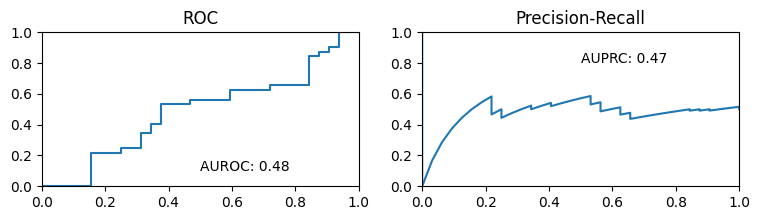

In [12]:
def prediction_fn(data):
    params = lr_model.sample(128)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [31]:
if dataset == "ovarian":
    batch = next(iter(data_factory_factory(batch_size=56)()))
else:
    batch = next(iter(data_factory_factory()()))
params = lr_model.sample(128)


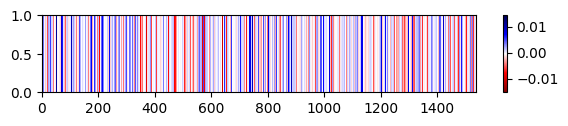

In [32]:
beta = tf.reduce_mean(params['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [37]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    beta = params["beta__"]
    intercept = params["intercept__"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.squeeze(tf.cast(data["y"], self.dtype))
    mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
        log_pi += self.prior_distribution.log_prob(
            {
                "regression_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.regression_var_list
                },
                "intercept_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.intercept_var_list
                },
            }
        )

        # pi \propto
        # log_pi.shape: [samples]

        # log_ell.shape  [samples, data]
        # X.shape [data, features]
        log_ell_tot = tf.reduce_sum(log_ell[..., tf.newaxis], axis=1, keepdims=True)
        grad_log_pi = tf.concat(
            [
                log_ell_tot,
                tf.reduce_sum(log_ell[..., tf.newaxis] * X, axis=1, keepdims=True),
            ],
            axis=-1,
        )
        # TODO NEED PRIOR TERM

        # grad_log_pi.shape [samples, 1, parameters]

        prior_intercept_sd = (
            self.prior_distribution.model["intercept_model"]
            .model["intercept__"]
            .variance()
            ** 0.5
        )
        prior_beta_sd = params["global_scale"]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0)

        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        # log_pi.shape: [samples]
        # mu.shape: [samples, data]
        # y.shape [data]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + ((1 - 2 * y)[:, tf.newaxis] * X)[tf.newaxis, :, :]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta + Q[..., tf.newaxis],
            intercept + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        transformed = params.copy()
        transformed["beta__"] = beta_new[..., tf.newaxis, :]
        transformed["intercept__"] = intercept_new[..., tf.newaxis, :]
        transformed["global_scale"] = transformed["global_scale"][..., tf.newaxis, :]
        transformed["global_scale_aux"] = transformed["global_scale_aux"][
            ..., tf.newaxis, :
        ]

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * data["X"], -1)
                + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(1-y, 1-ell_cross)
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_pi_new = self.prior_distribution.log_prob(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )
            log_pi_new += ell_cross
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis]

        log_eta_weights = delta_log_pi - log_ell_new + logJ
        log_eta_weights -= tf.reduce_max(log_eta_weights, axis=0, keepdims=True)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)
    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)

    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


loo = adaptive_is_loo(lr_model, batch, params, .2, variational=True)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.044392422553752 entropy: 14.897605190345848 khat>0.7: 0
LL: 0.04483060187297114 entropy: 13.438494297883725 khat>0.7: 15
KL: 0.04483060187297114 entropy: 14.878541603094618 khat>0.7: 0
Var: 0.04486557905949465 entropy: 14.877702588749754 khat>0.7: 0


In [38]:
loo["I"]['khat'] - loo['KL']['khat']

array([ 0.03336679, -0.05164323,  0.00232038,  0.0077079 , -0.0290751 ,
        0.01591718, -0.00319762, -0.01704738,  0.04664824,  0.02163838,
        0.02760373,  0.07395099,  0.05092286,  0.0113763 ,  0.02812452,
        0.03262335,  0.05597563, -0.237214  , -0.00159296,  0.04877013,
        0.00863585,  0.01545943,  0.01136208,  0.01234846,  0.02235455,
       -0.00918549,  0.07235   ,  0.1039851 , -0.41936513, -0.02771033,
        0.03159119, -0.00661504,  0.04624184, -0.53112767, -0.00532987,
        0.09189627, -0.00430963, -0.32593638,  0.08777223, -0.03910403,
        0.02451907, -0.00907697, -0.00129697,  0.04263517, -0.00270954,
       -0.00594475, -0.00336152,  0.06068598, -0.00290568,  0.00671074,
       -0.00432407,  0.00571109, -0.00247765,  0.00441192, -0.00370674,
        0.01036642])

# Compute LOO AU ROC/PRC

In [17]:
step_size = 0.2
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_loo']
    return pred



In [18]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



0it [00:00, ?it/s]

1it [00:00,  1.15it/s]
1it [00:00,  1.14it/s]


Step-away LOO

(0.0, 1.0)

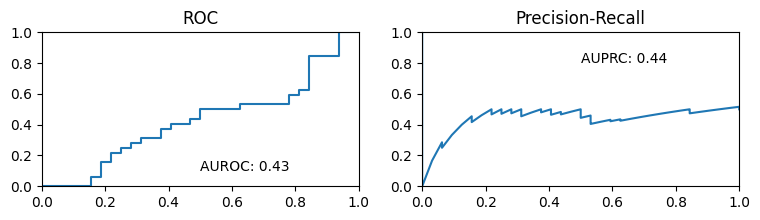

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

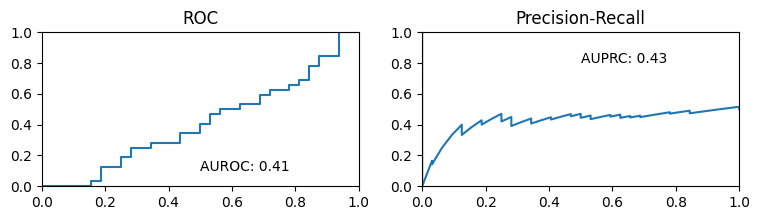

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

In [21]:
bench['auroc']['auroc']

0.484375

In [22]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(batch_size=1000, repeat=False)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=True)]

0it [00:00, ?it/s]

1it [00:01,  1.40s/it]


In [23]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [24]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

In [25]:
khat

{'I': array([-0.13057743, -0.25383724, -0.38352315, -0.18499776, -0.04014758,
        -0.19808312, -0.16729724, -0.15235533, -0.0110676 , -0.27120755,
        -0.46033737, -0.43787405, -0.38997839, -0.36872492, -0.43146061,
        -0.46589073, -0.52623795, -0.46568574, -0.4262345 , -0.45645538,
        -0.37505238, -0.51220048, -0.41826935, -0.42557708, -0.4243188 ,
        -0.50301477, -0.45264786, -0.47272841, -0.48838119, -0.48906227,
        -0.40046484, -0.46175932, -0.3864201 , -0.49239063, -0.33365754,
        -0.36074982, -0.39277304, -0.41767611, -0.47208619, -0.27810383,
        -0.31403234, -0.3848656 , -0.31887623, -0.34726281, -0.33149888,
        -0.3825156 , -0.43828639, -0.44286677, -0.39582645, -0.34067783,
        -0.39843086, -0.39756532, -0.35308001, -0.46443231, -0.346041  ,
        -0.42022587, -0.42665195, -0.46354307, -0.4467593 , -0.31048102,
        -0.40689239, -0.29684094, -0.39481037, -0.48577438]),
 'LL': array([1.89064149, 1.99885026, 2.26967448, 1.93383

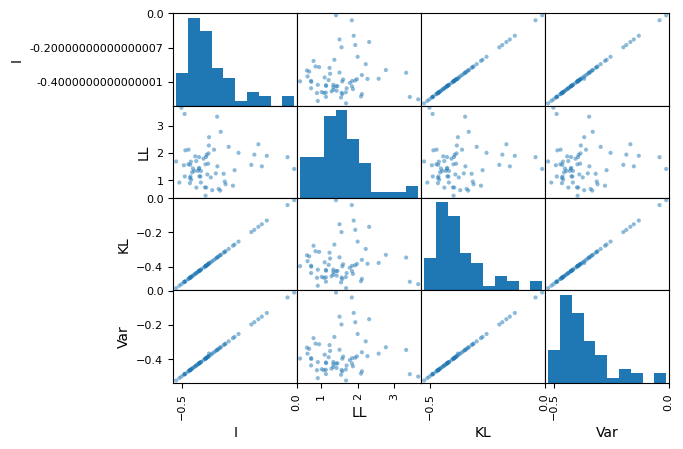

In [26]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


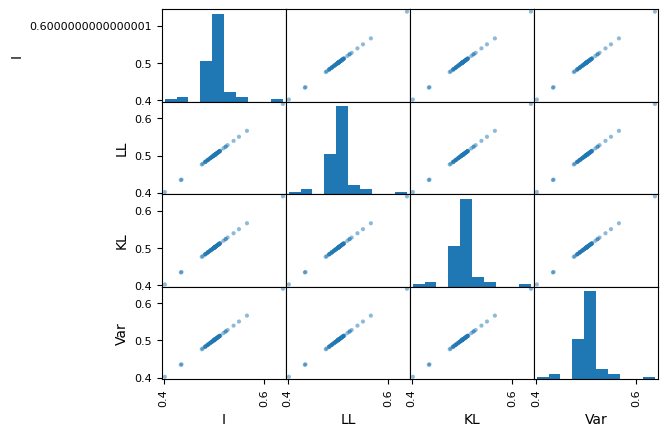

In [27]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [28]:
khat.describe()

,I,LL,KL,Var
count,64.000000,64.000000,64.000000,64.000000
mean,-0.376368,1.542146,-0.376311,-0.376151
std,0.109366,0.668750,0.109364,0.109368
min,-0.526238,0.417989,-0.526238,-0.526238
25%,-0.453600,1.116624,-0.453600,-0.453600
50%,-0.397998,1.472764,-0.397998,-0.397998
75%,-0.338923,1.875054,-0.338923,-0.338923
max,-0.011068,3.663036,-0.011068,-0.011068


In [29]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [30]:
(khat>0.5).describe()

,I,LL,KL,Var
count,64,64,64,64
unique,1,2,1,1
top,False,True,False,False
freq,64,63,64,64
